# Larger network power optimization with realistic scenarios for renewable energy sources

In [1]:
import pandas as pd
import warnings
import numpy as np
from dwave.system.samplers import LeapHybridSampler, DWaveSampler
from dimod import BinaryQuadraticModel, ExactSolver
from dwave.system.composites import EmbeddingComposite
from neal import SimulatedAnnealingSampler
from datetime import datetime as dt
from matplotlib import pyplot as plt
from src.utils.BQM import multisource_plot
import dimod

# Input Data

The input data for the demand is the same as used in the main notebook.

## Power Demand

Here we use real data sets from the sources below to test our algorithm.  We import the hour by hour load and generation cost data for Italy in 2014.

Power Demand: https://www.entsoe.eu/data/data-portal/

Generation costs https://www.eia.gov/electricity/annual/html/epa_08_04.html

In [2]:
IT_data = pd.read_excel('./data/Monthly-hourly-load-values_2014_IT.xlsx')

In [3]:
demand = []
for i in range(len(IT_data)):
    demand += list((IT_data.iloc[i,6:30]))

## Renewable energy production

The production of renewables such as solar and wind power comes with a variability that is important to model in these types of simulations.  We can model this with a coefficient called a capacity factor.  The capicity factor tells us at what percentage of its maximum output it is producing during any specific hour of the day.



### Variability of Solar Power

The [**duck curve**](https://en.wikipedia.org/wiki/Duck_curve) is a graph of power production over the course of a day that shows the timing imbalance between peak demand and renewable energy production. Clearly, for solar energy, more solar power is generated when the sun is out. 
We model this with a set of capacity factors that approach 1 during daylight hours, while tend to 0 for the night hours. 

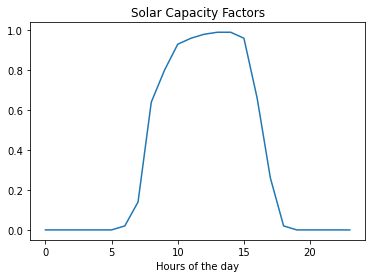

In [4]:
# Solar Production capacity factors over a day

solar_capacity_factors = [0,0,0,0,0,0,0.02,0.14,0.64,0.8,0.93,0.96,0.98,0.99,0.99,0.96,0.66,0.26,0.02,0,0,0,0,0]

plt.plot(solar_capacity_factors[0:24], label='demand')
plt.xlabel('Hours of the day')
plt.title('Solar Capacity Factors')
plt.show()

### Variability of Wind Power
Wind power is intrinsically stochastic. Such stochasticity can be modeled by adding a volatile (random) component to the capacity factors. We use a capacity factor as being baseline at an average of 50% +/- %50 modeling the wind blowing more or less strongly (variability of 30%).


In [5]:
# Variable wind capacity factors over a day
wind_capacity_factors = []
for i in range(24):
    wind_var =0.5*np.random.random() # accounts for variance of the wind
    wind_capacity_factors.append(0.5 + 0.5*wind_var) 

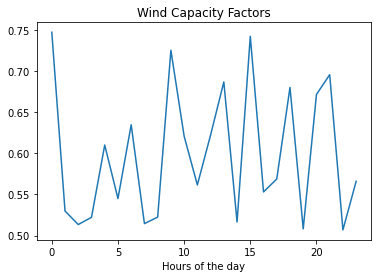

In [6]:
plt.plot(wind_capacity_factors[0:24], label='demand')
plt.xlabel('Hours of the day')

plt.title('Wind Capacity Factors')
plt.show()

## Plant Operating Cost

In this section we consider six categories of power generation:
Nuclear, Coal, Hydro, Gas, Solar, and Wind.

We collect average operating costs for the different types of generation from the source below.
They include three numbers in milles per kwh:
Operating Costs, Maintanence Costs, Fuel Costs

https://www.eia.gov/electricity/annual/html/epa_08_04.html

### Nuclear 'n', Coal 'c', Hydro 'h', Gas 'g', Solar 's', Wind 'w'


In [7]:
#Operating costs by plant type(Operation,Maintenance,Fuel) mills per kwh
operating_costs = [('n',11.17+7.06+7.48),('c',5.16+5.41+26.70),('h',8.37+5.06),('g',2.34+2.68+28.22),('s',5.16+5.41),('w',5.16+5.41)]
sources = [operating_costs[i][0] for i in range(len(operating_costs))]

# Optimization

Running over 1 days at 24 hourly intervals.

Here we look at the effect of switching costs, emission, and amount of power generation.
The order of the indices correspond to the order of the title above.

In [8]:
np.random.seed(123)
n_schedules = 24

# define binary variables
schedules = [f's_{i}' for i in range(n_schedules)]
n_energy_sources = len(sources)
#2000 is a normalization factor scaling the total demand in Italy to the size of your problem
demand_schedule = [i/2000 for i in demand[0:n_schedules]]    

#Defining capacity factors for all power sources
capacity_factors = [[1]*24 for i in range(len(sources))]
capacity_factors[4]= solar_capacity_factors
capacity_factors[5]=wind_capacity_factors
cost_usage = [operating_costs[i][1] for i in range(len(operating_costs))]

# define the cost to switch off/on one of the energy sources
# nuclear is expensive to turn on/off for example, gas can switch on quickly
cost_switch = [50, 8, 2, 1,1,1]

# define the carbon emission per kWh
#Coal and Gas have high emissions while renewables have much lower emissions
cost_emission = [0, 20, 2, 20,0,0]


#Power generation per type
#Here is the basic max power generation capacity for each type of power
power_generation = [6, 6, 3, 5,8,6]

# Defining our BQM

In [9]:
# define BQM
bqm = BinaryQuadraticModel(dimod.BINARY)

# add a variable for each schedule and energy source
for s in schedules:
    for alpha in sources:
        bqm.add_variable(s+alpha)

# Objective
# linear components
for i in range(n_schedules):
    for alpha in range(n_energy_sources):
        bqm.set_linear(f's_{i}'+sources[alpha], (cost_usage[alpha] + cost_emission[alpha]))
 

# Constraints
# Switching Constraints
for i in range(n_schedules-1):
    for alpha in range(n_energy_sources):
        for beta in range(n_energy_sources):
            if alpha != beta:
                bqm.set_quadratic(f's_{i}'+sources[alpha], f's_{i+1}'+sources[beta], cost_switch[alpha] + cost_switch[beta])


# lb <= \sum_{i,k} a_{i,k} x_{i,k} + constant <= ub
# equality constraint: power > demand
for i in range(n_schedules):
    for alpha in range(n_energy_sources):
            bqm.add_linear_equality_constraint(      
            [(f's_{i}'+sources[alpha], capacity_factors[alpha][i]*power_generation[alpha]) for alpha in range(n_energy_sources)],
            constant=-demand_schedule[i],
            lagrange_multiplier=800,
        )

# Running the Simulation

## Leap Hybrid Solver
First we run the optimization on the leap hybrid annealer.


In [10]:
# Leap hybrid solver
sampler = LeapHybridSampler()
res = sampler.sample(bqm, time_limit=50)
#print(res.aggregate())
df = res.aggregate().to_pandas_dataframe()


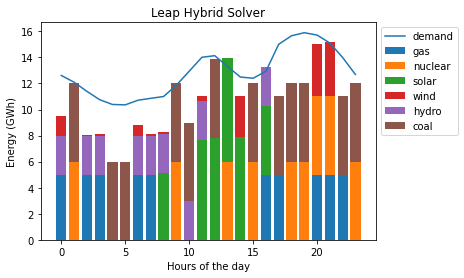

In [11]:
multisource_plot(df,sources,power_generation,demand_schedule,capacity_factors,'hybrid')

## Simulated Annealing

Next we test our QUBO on simulated annealer plotting the results.

In [12]:
# Simulated annealing
classical_sampler = SimulatedAnnealingSampler()
start = dt.now()
classical_res = classical_sampler.sample(bqm,num_reads=1)
#print(classical_res.aggregate())
df = classical_res.aggregate().to_pandas_dataframe()
df=df[df.energy == df.energy.min()]

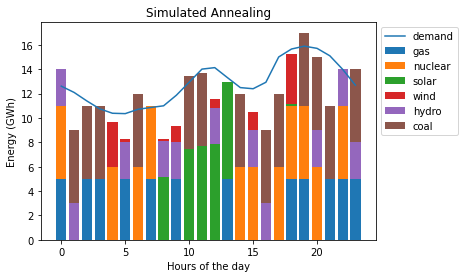

In [13]:
multisource_plot(df,sources,power_generation,demand_schedule,capacity_factors,gtype = 'sa')

## Running on QPU

In [14]:
# # QPU solver
sampler = EmbeddingComposite(DWaveSampler(solver='DW_2000Q_6',num_reads=1))
res = sampler.sample(bqm)

#print(res.aggregate())
df = res.aggregate().to_pandas_dataframe()
df=df[df.energy == df.energy.min()]
del df['chain_break_fraction']

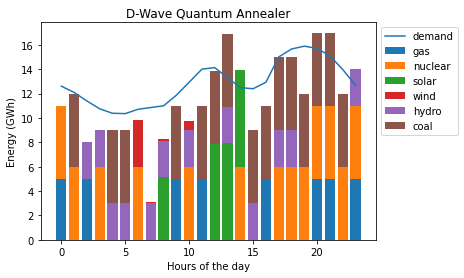

In [15]:
multisource_plot(df,sources,power_generation,demand_schedule,capacity_factors,'qpu')